In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, activations
from os.path import join, basename, exists
from os import mkdir
import itertools
import pandas as pd
import sys
from keras import backend as K
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import random
import pandas as pd
from keras.layers import *
from keras import metrics
from scipy.stats.stats import pearsonr
from datetime import datetime
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sb
from IPython.display import clear_output
import json
from cgr_model import TwinModel, train_submodels, get_individual_predictions

2023-09-15 14:19:46.903984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/_j/jxj9zb555rx6r9825t1lmz_r000fpf/T/ipykernel_4275/2440279263.py:18: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Train and test the PPI Pre benchmark data on ensemble of CGR models

## Negatome data

In [17]:
datasets = ['negatome','recombine']
data_parent = 'data/0000_datasets_as_used_in_paper/PPIPre_benchmark_data/'
directory='data/0007_ppipre_benchmark_data/'
dataset_name='Negatome'
if not exists(join(directory, dataset_name)):
    mkdir(join(directory, dataset_name))
out_parent = join(directory, dataset_name, 'Out')
if not exists(out_parent):
    mkdir(out_parent)
out_checkpoints = join(out_parent, 'checkpoints')
if not exists(out_checkpoints):
    mkdir(out_checkpoints)

In [3]:
# Load in details of each model in ensemble:
with open(join(directory,'submodel_params.json'), 'r') as param_file:
    submodel_params = json.load(param_file)

In [ ]:
# Best test acc. from the combinations with the highest val. acc.

# Go through and train a model on the training data for each submodel in the ensemble. Save a checkpoint model.
# (Actually run elsewhere)
for i in [2, 3, 4, 7, 10, 14, 15, 18, 21, 22]:
    params = submodel_params[i]
    data_file = f'{data_parent}/{dataset_name}/{params["k"]}_randomised.npz'
    train_submodels(params,i,data_file,dataset_name, out_checkpoints, 1)
    

In [12]:
def get_votes(prediction_list, index_list,class_threshold=0.5):
    test_votes = np.zeros((len(prediction_list[0]),))
    for row in prediction_list:
        classifications = row > class_threshold
        test_votes+=classifications
    return test_votes

In [19]:
# Load in each checkpoint in turn and get predictions, then get the voted-on total prediction
dataset_name = 'Negatome'
all_test_predictions=[]
individual_test_results=[]
saved_data = np.load(f'{data_parent}/{dataset_name}/4_randomised.npz')
actual_test_y = saved_data['test_Y']
index_list=[2, 3, 4, 7, 10, 14, 15, 18, 21, 22]
for i in index_list:
    params = submodel_params[i]
    k=params['k']
    data_file = f'{data_parent}/{dataset_name}/{params["k"]}_randomised.npz'
    predictions,results = get_individual_predictions(params, i, 0, data_file,'test',
                                                    join(out_checkpoints, f'{dataset_name}_{k}mers_{i}_0'))
    all_test_predictions.append(predictions)
    individual_test_results.append(results)
mean_pred_test = np.array(all_test_predictions).squeeze().mean(axis=0)
all_test_predictions_np = np.array(all_test_predictions).squeeze()
voted_predictions = get_votes(all_test_predictions_np,index_list)>(np.floor(len(index_list)/2))
score = accuracy_score(actual_test_y, voted_predictions).squeeze()
plot_predictions(voted_predictions,actual_test_y)

tf.Tensor(0.0010000000474974513, shape=(), dtype=float64) 0.01 0.001
77/77 [==============================] - 27s 344ms/step - loss: 1.0070 - acc: 0.9016 - recall: 0.8913 - precision: 0.9196
tf.Tensor(0.009999999776482582, shape=(), dtype=float64) 0.01 0.0001
77/77 [==============================] - 69s 885ms/step - loss: 154.3386 - acc: 0.8565 - recall: 0.8535 - precision: 0.8717
tf.Tensor(0.001500000013038516, shape=(), dtype=float64) 0.01 0.001
77/77 [==============================] - 1s 11ms/step - loss: 0.6593 - acc: 0.8695 - recall: 0.8820 - precision: 0.8720
tf.Tensor(0.001500000013038516, shape=(), dtype=float64) 0.01 1e-05
77/77 [==============================] - 3s 30ms/step - loss: 0.6472 - acc: 0.8659 - recall: 0.8219 - precision: 0.9150
tf.Tensor(0.0010000000474974513, shape=(), dtype=float64) 0.01 0.001
77/77 [==============================] - 101s 1s/step - loss: 0.7892 - acc: 0.8947 - recall: 0.9106 - precision: 0.8920
tf.Tensor(0.0010000000474974513, shape=(), dtype=fl

77/77 [==============================] - 77s 994ms/step - loss: 0.7783 - acc: 0.9061 - recall: 0.9075 - precision: 0.9138
tf.Tensor(0.001500000013038516, shape=(), dtype=float64) 0.001 0.01
77/77 [==============================] - 70s 910ms/step - loss: 0.6890 - acc: 0.8882 - recall: 0.8959 - precision: 0.8925
tf.Tensor(0.0010000000474974513, shape=(), dtype=float64) 0.01 0.0001
77/77 [==============================] - 114s 1s/step - loss: 0.8178 - acc: 0.8272 - recall: 0.7710 - precision: 0.8865
tf.Tensor(0.001500000013038516, shape=(), dtype=float64) 0.01 0.001
77/77 [==============================] - 3s 29ms/step - loss: 2.2264 - acc: 0.8699 - recall: 0.8689 - precision: 0.8825
precision: 0.95 recall: 0.86
f1: 0.90 accuracy: 0.90


In [14]:
def plot_predictions(predictions, actual):
    class_predictions = predictions > 0.5
    tp = np.count_nonzero((class_predictions == 1) & (actual == 1))
    fp = np.count_nonzero((class_predictions == 1) & (actual == 0))
    tn = np.count_nonzero((class_predictions == 0) & (actual == 0))
    fn = np.count_nonzero((class_predictions == 0) & (actual == 1))
    total = tp + fp + tn + fn
    f1 = tp / (tp + 1/2 * (fp + fn))
    acc = (tp+tn) / (total)
    if tp+fp == 0:
        prec = 0
    else:
        prec = tp / (tp+fp)
    recall = tp / (tp + fn)
    print('precision: {:.2f}'.format(prec),'recall: {:.2f}'.format(recall))
    print('f1: {:.2f}'.format(f1),'accuracy: {:.2f}'.format(acc))

def plot_confusion_matrix(conf):
    print(conf)
    row_sums = conf.sum(axis=1)
    conf = conf / row_sums[:, np.newaxis]
    print(conf)
    plt.imshow(conf, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.yticks([0,1])
    plt.xticks([0,1])
    midp = (np.amax(conf)+np.amin(conf))/2
    for i in range(2):
        for j in range(2):
            if conf[i][j] > midp:
                colour = 'w'
            else:
                colour = 'k'
            plt.text(j,i,'{:.2f}'.format(conf[i][j]),c=colour)
    plt.show()

[[1102   61]
 [ 181 1116]]
[[0.94754944 0.05245056]
 [0.13955281 0.86044719]]


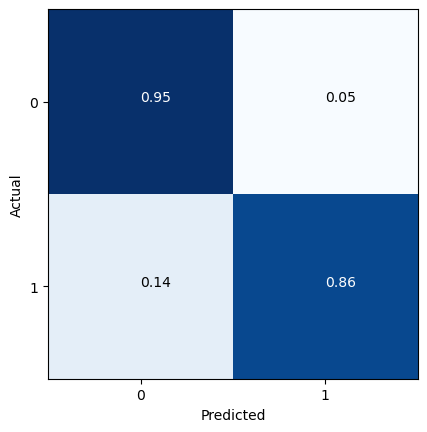

In [20]:
plot_confusion_matrix(confusion_matrix(actual_test_y, voted_predictions))

# Recombine data

In [8]:
dataset_name = 'Recombine'
if not exists(join(directory, dataset_name)):
    mkdir(join(directory, dataset_name))
out_parent = join(directory, dataset_name, 'Out')
if not exists(out_parent):
    mkdir(out_parent)
out_checkpoints = join(out_parent, 'checkpoints')
if not exists(out_checkpoints):
    mkdir(out_checkpoints)


In [ ]:
# Best test acc. from the combinations with the highest val. acc.
for i in [2, 3, 4, 7, 10, 14, 15, 18, 21, 22]:
    params = submodel_params[i]
    data_file = f'{data_parent}/{dataset_name}/{params["k"]}_randomised.npz'
    train_submodels(params,i,data_file,dataset_name,1)

In [ ]:
dataset_name = 'Recombine'
all_test_predictions=[]
individual_test_results=[]
saved_data = np.load(f'{data_parent}/{dataset_name}/4_randomised.npz')
actual_test_y = saved_data['test_Y']
index_list=[2, 3, 4, 7, 10, 14, 15, 18, 21, 22]
for i in index_list:
    params = submodel_params[i]
    k=params['k']
    data_file = f'{data_parent}/{dataset_name}/{params["k"]}_randomised.npz'
    predictions,results = get_individual_predictions(params, i, 0, data_file,'test',
                                                    join(out_checkpoints, f'{dataset_name}_{k}mers_{i}_0'))
    all_test_predictions.append(predictions)
    individual_test_results.append(results)
mean_pred_test = np.array(all_test_predictions).squeeze().mean(axis=0)
all_test_predictions_np = np.array(all_test_predictions).squeeze()
voted_predictions = get_votes(all_test_predictions_np,index_list)>(np.floor(len(index_list)/2))
score = accuracy_score(actual_test_y, voted_predictions).squeeze()
plot_predictions(voted_predictions,actual_test_y)

In [15]:
voted_predictions = get_votes(all_test_predictions_np,index_list)>(np.floor(len(index_list)/2))
score = accuracy_score(actual_test_y, voted_predictions).squeeze()
plot_predictions(voted_predictions,actual_test_y)

precision: 0.72 recall: 0.89
f1: 0.79 accuracy: 0.77


[[ 826  452]
 [ 147 1143]]
[[0.64632238 0.35367762]
 [0.11395349 0.88604651]]


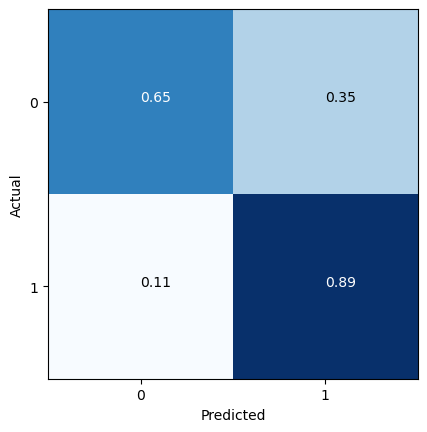

In [16]:
plot_confusion_matrix(confusion_matrix(actual_test_y, voted_predictions))